# <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2; text-align: center;">Neural Networks</div>

We tried to test the use of some feedforward neural networks developed with the
help of the Keras library.

The first model was a simple one, that only has a few layers and neurons, with
not a great performance. The second, was much bigger, and it seemed to perform
better between the 2. In any case, the random forest, and other models we talk
about in this project had much higher performance, so we did not end up using
this style of model as much as we were expecting.


In [9]:
from mlflow.create_dataset import Dataset, DATASET_TARGET_FEATURES
dataset = Dataset()
X,y = dataset.with_correlation()

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Test 1: Simple neural network</div>

This was the initial test.

### Model Creation

In [10]:
import keras as kr

FIT_PARAMS = {
    "batch_size": 64, # change this to try different tests
    "epochs": 100,
    "shuffle": True,
}
MODEL_NAME = "nn_1"

n_features = len(X.columns)
n_targets  = len(y.columns)
relu_slope = lambda x: kr.activations.relu(x, negative_slope=0.2)
nn_input = kr.Input(shape=(n_features,))
x = kr.layers.Dense(15, activation=relu_slope)(nn_input)
x = kr.layers.Dense(10, activation=relu_slope)(x)
x = kr.layers.Dense(7, activation=relu_slope)(x)
nn_output = kr.layers.Dense(n_targets, activation="softmax")(x)
model = kr.Model(inputs=nn_input, outputs=nn_output)
model.compile(
    optimizer=kr.optimizers.RMSprop(),  # Optimizer # type: ignore
    # Loss function to minimize
    loss=kr.losses.MeanSquaredError(),
    
    # List of metrics to monitor
    metrics=["accuracy", "auc"],
)

### Training & Execution

In [11]:
import logging
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mlflow.create_dataset import DATASET_TARGET_FEATURES


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
early_stopping = kr.callbacks.EarlyStopping(  # to improve the performance of the model
    monitor="val_auc", patience=10, restore_best_weights=True
)

model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    **FIT_PARAMS,
)
print(f"Model trained")


predictions: np.ndarray = model.predict(dataset.test)
predictions = predictions.transpose()

h1n1_probs = predictions[0][:]
# Probabilidades de clase positiva para h1n1_vaccine
seasonal_probs = predictions[1][:]
# Probabilidades de clase positiva para seasonal_vaccine

predict = pd.DataFrame(
    {
        "respondent_id": dataset.test.index,
        "h1n1_vaccine": h1n1_probs,
        "seasonal_vaccine": seasonal_probs,
    }
)
predict.set_index("respondent_id", inplace=True)
predict.to_csv(f"predictions_{MODEL_NAME}.csv")
print("predictions saved")

Epoch 1/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3384 - auc: 0.6774 - loss: 0.2314 - val_accuracy: 0.4075 - val_auc: 0.7043 - val_loss: 0.2240
Epoch 2/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3886 - auc: 0.7110 - loss: 0.2221 - val_accuracy: 0.3950 - val_auc: 0.7117 - val_loss: 0.2211
Epoch 3/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4077 - auc: 0.7139 - loss: 0.2205 - val_accuracy: 0.3765 - val_auc: 0.7145 - val_loss: 0.2201
Epoch 4/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3897 - auc: 0.7173 - loss: 0.2194 - val_accuracy: 0.3531 - val_auc: 0.7149 - val_loss: 0.2202
Epoch 5/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4001 - auc: 0.7179 - loss: 0.2188 - val_accuracy: 0.4266 - val_auc: 0.7146 - val_loss: 0.2196
Epoch 6/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3986 - auc: 0.7190 - loss: 0.2189 - val_accuracy: 0.3993 - val_auc: 0.7166 - val_loss: 0.2191
Epoch 7/100
334/334 ━━━━━━━━━━━━━━

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Results</div>

In [12]:
from pandas import DataFrame
from sklearn.metrics import classification_report

y_pred_proba = DataFrame(model.predict(X_test),columns=DATASET_TARGET_FEATURES)# model.predict(X_test),columns=DATASET_TARGET_FEATURES)
y_pred = y_pred_proba.map(lambda x:0 if x<0.5 else 1)

print(classification_report(y_test, y_pred, zero_division=0))

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
              precision    recall  f1-score   support

           0       0.28      0.12      0.17      1135
           1       0.49      0.95      0.64      2488

   micro avg       0.47      0.69      0.56      3623
   macro avg       0.38      0.54      0.41      3623
weighted avg       0.42      0.69      0.49      3623
 samples avg       0.47      0.38      0.41      3623



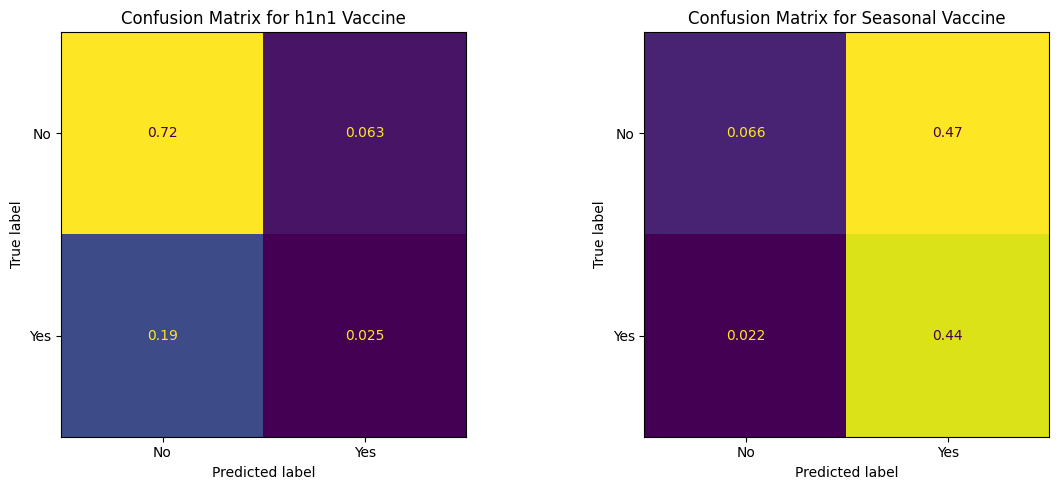

In [13]:
# confusion matrices
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# H1N1 vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred['h1n1_vaccine'], normalize='all')
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['No', 'Yes'])
disp_h1n1.plot(ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix for h1n1 Vaccine')

# Confusion matrix for seasonal vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred['seasonal_vaccine'], normalize='all')
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['No', 'Yes'])
disp_seasonal.plot(ax=ax[1], colorbar=False)
ax[1].set_title('Confusion Matrix for Seasonal Vaccine')

plt.tight_layout()
plt.show()

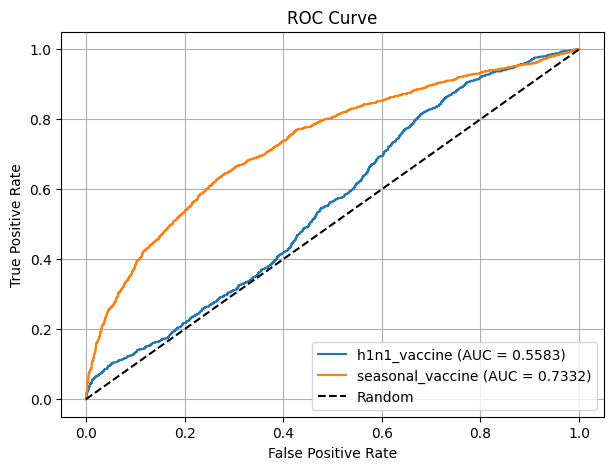

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred_proba.iloc[:, i])
    auc = roc_auc_score(y_test.iloc[:, i], y_pred_proba.iloc[:, i])
    plt.plot(fpr, tpr, label=f'{y_test.columns[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

As we can see in the confusion matrix, this model seems to always pick the same classification for vaccine groups regardless of the input data. This means it is inadequate for classification.

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Test 2: Bigger neural network, with a some dropout layers in between</div>

This model is similar to the one developed before, but bigger. It also has some dropout layers.

### Model Creation

In [5]:
FIT_PARAMS = {
    "batch_size": 64, # change this to try different tests
    "epochs": 100,
    "shuffle": True,
}
MODEL_NAME = "nn_3"

nn_input = kr.Input(shape=(n_features,))
x = kr.layers.Dense(512, activation='relu')(nn_input) #what ever other input and activation function
x = kr.layers.Dense(256, activation='relu', kernel_regularizer=kr.regularizers.l2(0.01))(x)
x = kr.layers.Dropout(0.3)(x)
x = kr.layers.Dense(128, activation='relu')(x)
x = kr.layers.Dense(64, activation='sigmoid')(x)
x = kr.layers.Dropout(0.2)(x)
x = kr.layers.Dense(32, activation='relu')(x)
nn_output = kr.layers.Dense(n_targets, activation="sigmoid")(x) # SIGMOID better than SOFTMAX

model = kr.Model(inputs=nn_input, outputs=nn_output)
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),  
    # Loss function to minimize
    loss=kr.losses.BinaryCrossentropy(), # THIS ONE DO NOT CHANGE
    # List of metrics to monitor
    metrics=["accuracy", kr.metrics.AUC(name="auc", multi_label=True)],
)

### Training & Execution

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mlflow.create_dataset import DATASET_TARGET_FEATURES


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=43, stratify=y
)
early_stopping = kr.callbacks.EarlyStopping(  # to improve the performance of the model
    monitor="val_auc", patience=10, restore_best_weights=True
)

model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    **FIT_PARAMS,
)
print(f"Model trained")


predictions: np.ndarray = model.predict(dataset.test)
predictions = predictions.transpose()

h1n1_probs = predictions[0][:]
# Probabilidades de clase positiva para h1n1_vaccine
seasonal_probs = predictions[1][:]
# Probabilidades de clase positiva para seasonal_vaccine

predict = pd.DataFrame(
    {
        "respondent_id": dataset.test.index,
        "h1n1_vaccine": h1n1_probs,
        "seasonal_vaccine": seasonal_probs,
    }
)
predict.set_index("respondent_id", inplace=True)
predict.to_csv(f"predictions_{MODEL_NAME}.csv")
print("predictions saved")

Epoch 1/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3269 - auc: 0.7135 - loss: 1.4078 - val_accuracy: 0.2976 - val_auc: 0.8290 - val_loss: 0.4677
Epoch 2/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3344 - auc: 0.8243 - loss: 0.4701 - val_accuracy: 0.3620 - val_auc: 0.8371 - val_loss: 0.4699
Epoch 3/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3267 - auc: 0.8314 - loss: 0.4590 - val_accuracy: 0.3297 - val_auc: 0.8431 - val_loss: 0.4450
Epoch 4/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3366 - auc: 0.8356 - loss: 0.4496 - val_accuracy: 0.3031 - val_auc: 0.8428 - val_loss: 0.4453
Epoch 5/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3402 - auc: 0.8418 - loss: 0.4478 - val_accuracy: 0.3248 - val_auc: 0.8425 - val_loss: 0.4517
Epoch 6/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3371 - auc: 0.8445 - loss: 0.4416 - val_accuracy: 0.3465 - val_auc: 0.8455 - val_loss: 0.4410
Epoch 7/100
334/334 ━━━━━━━━━━━━━━

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Results</div>

In [7]:
from pandas import DataFrame
from sklearn.metrics import classification_report

y_pred_proba = DataFrame(model.predict(X_test),columns=DATASET_TARGET_FEATURES)# model.predict(X_test),columns=DATASET_TARGET_FEATURES)
y_pred = y_pred_proba.map(lambda x:0 if x<0.5 else 1)

print(classification_report(y_test, y_pred, zero_division=0))

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
              precision    recall  f1-score   support

           0       0.73      0.47      0.57      1135
           1       0.75      0.77      0.76      2488

   micro avg       0.74      0.67      0.71      3623
   macro avg       0.74      0.62      0.66      3623
weighted avg       0.74      0.67      0.70      3623
 samples avg       0.36      0.34      0.34      3623



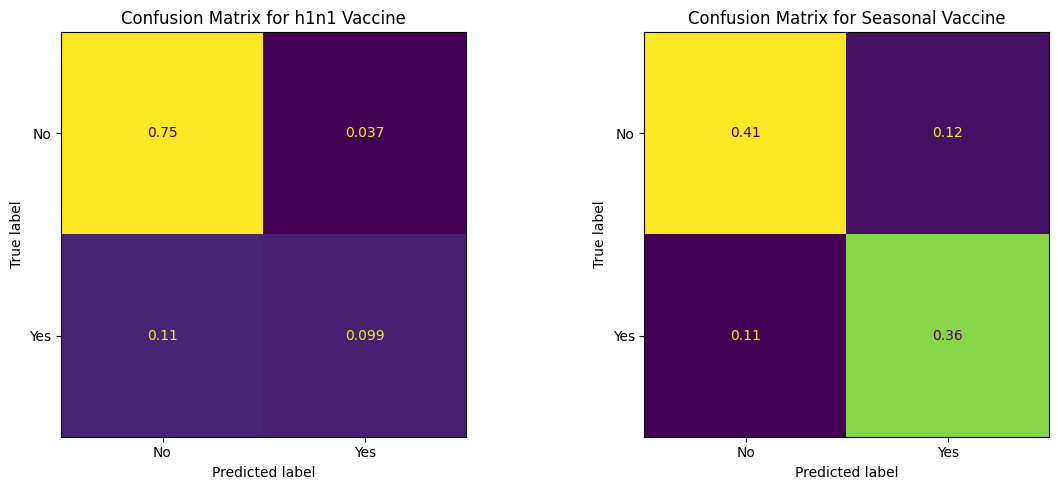

In [8]:
# confusion matrices
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# H1N1 vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred['h1n1_vaccine'], normalize='all')
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['No', 'Yes'])
disp_h1n1.plot(ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix for h1n1 Vaccine')

# Confusion matrix for seasonal vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred['seasonal_vaccine'], normalize='all')
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['No', 'Yes'])
disp_seasonal.plot(ax=ax[1], colorbar=False)
ax[1].set_title('Confusion Matrix for Seasonal Vaccine')

plt.tight_layout()
plt.show()

As the confusion matrix shows, the model is inadequate for classifying h1n1 vaccination, since the predicted label is no, almost always. 

For seasonal vaccines, it can be used for classification, since the matrix is at least in an acceptable state.

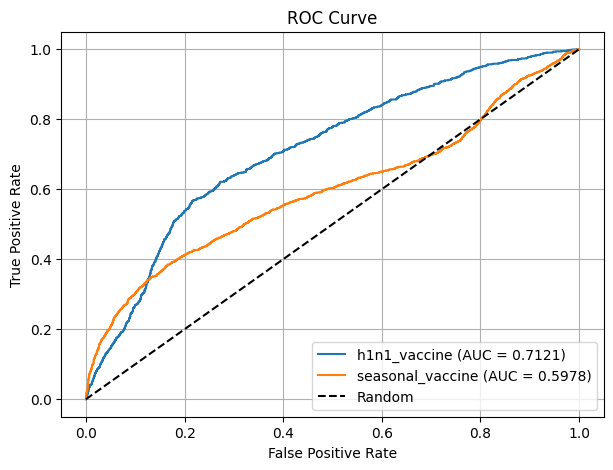

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred_proba.iloc[:, i])
    auc = roc_auc_score(y_test.iloc[:, i], y_pred_proba.iloc[:, i])
    plt.plot(fpr, tpr, label=f'{y_test.columns[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

The ROC curve is better in the case of the h1n1 vaccine, but as we saw before, this one only predicts the output "No". The fact it is like this may be because of the imbalance in the dataset with respect to the n1n1 vaccine (this can be seen just before, in the true label part of the confusion matrix).

The ROC curve for the seasonal vaccine is, on the othe hand, a lot worse.

We uploaded this last model to the contest, since it had the highest metrics in ROC and accuracy, and these were the results:

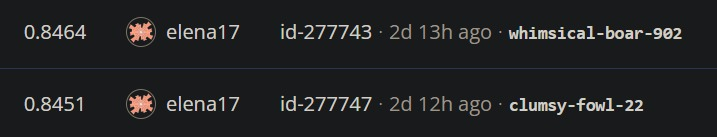

In my opinion, the reason behind the high ROC may be because of the ROC curve on the h1n1 vaccine output. This output, although with a high ROC area value, it seems to be very inaccurate according to the confusion matrix. What this suggests, in my opinion, is that the model's quality may be a lot lower than the ROC may suggest.